In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder
import pandas as pd

In [14]:
from numba import njit

@njit
def calculate_mentioned_together(ballots, num_candidates, num_ballots, num_ranks):
    mentioned_together = np.zeros((num_candidates, num_candidates))
    for i in range(num_ballots):
        for j in range(num_ranks):
            for k in range(num_ranks):
                if ballots[i, j] <= num_candidates and ballots[i, k] <= num_candidates:
                    mentioned_together[ballots[i, j]-1, ballots[i, k]-1] += 1
    return mentioned_together

In [15]:
def perform_rcv_analysis(csv_file, ignore_values=None, metric=True):
    if ignore_values is None:
        ignore_values = ['(WRITE-IN)', 'writein', 'Write-In', 'Write-in', 'skipped', 'overvote']

    # Load the CSV file
    df = pd.read_csv(csv_file)
    
    # Keep only the 'rank' columns
    df = df.filter(regex='^rank')

    # Filter out rows that contain non-candidate values
    df = df[~df.isin(ignore_values)].dropna()
    
    # Convert the DataFrame to a 2D list
    raw_ballots = df.values.tolist()

    # Create a list of all candidate names
    candidate_names = pd.unique(df.values.ravel())
    
    # Convert names to integer codes
    label_encoder = LabelEncoder()
    label_encoder.fit(candidate_names)
    ballots = [label_encoder.transform(ballot) for ballot in raw_ballots]
    candidate_names = label_encoder.classes_
    num_candidates = len(candidate_names)

    # Convert ballots to a NumPy array
    ballots = np.array(ballots)

    # Get the number of ballots and ranks
    num_ballots, num_ranks = ballots.shape

    # Count up frequencies of consecutive-pair ballot choices
    counts = np.zeros((num_candidates, num_candidates))
    for i in range(num_ballots):
        for j in range(num_ranks - 1):
            counts[ballots[i, j], ballots[i, j+1]] += 1

    # Calculate 'mentioned_together'
    mentioned_together = calculate_mentioned_together(ballots, num_candidates, num_ballots, num_ranks)

    # Normalize to frequencies relative to votes cast for the two candidates
    frequencies = counts / mentioned_together

    # Combine frequencies in either direction to create symmetric matrix
    freq_upper_triangle = np.zeros((num_candidates, num_candidates))
    for i in range(num_candidates):
        for j in range(i+1, num_candidates):
            freq_upper_triangle[i, j] = (frequencies[i, j] + frequencies[j, i]) / 2
            freq_upper_triangle[j, i] = freq_upper_triangle[i, j]

    # Compute 'd' (distance metric)
    min_freq = np.min(freq_upper_triangle[freq_upper_triangle > 0])
    distance = 1 / np.sqrt(freq_upper_triangle)
    distance[np.isnan(distance)] = 2 / min_freq
    distance[np.isinf(distance)] = 2 / min_freq
    np.fill_diagonal(distance, 0)

    # Perform nonmetric MDS for 1 dimension
    mds = MDS(n_components=1, metric=metric, dissimilarity='precomputed')
    y_values_1d = mds.fit_transform(distance)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(np.zeros_like(y_values_1d), y_values_1d)
    for i in range(num_candidates):
        plt.text(0.2, y_values_1d[i], candidate_names[i])
    plt.axis([-1, 1.5, y_values_1d.min()*1.2, y_values_1d.max()*1.2])
    plt.show()

    # Perform nonmetric MDS for 2 dimensions
    mds = MDS(n_components=2, metric=metric, dissimilarity='precomputed')
    y_values_2d = mds.fit_transform(distance)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_values_2d[:, 0], y_values_2d[:, 1])
    for i in range(num_candidates):
        plt.text(y_values_2d[i, 0], y_values_2d[i, 1], candidate_names[i])
    plt.grid(True)
    plt.show()

/var/folders/g2/25z774tn0599smwks8_v_k200000gp/T/ipykernel_6778/540560559.py:54: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)
/Users/es5891/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


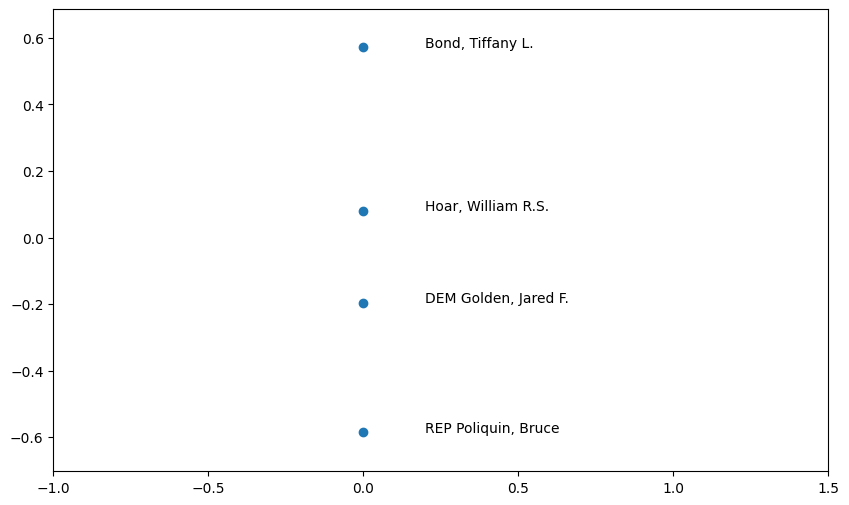

/Users/es5891/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


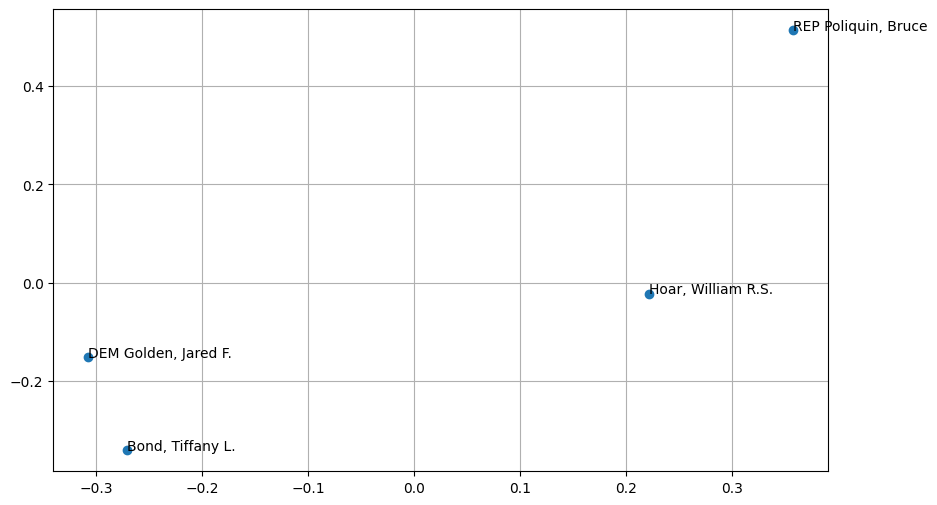

In [16]:
# Test the function with the provided CSV file
perform_rcv_analysis(f"Maine_11062018_CongressionalDistrict2.csv", ignore_values=['skipped', 'overvote', 'writein','Write-in'],metric=False)

/var/folders/g2/25z774tn0599smwks8_v_k200000gp/T/ipykernel_6778/540560559.py:54: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)
/Users/es5891/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


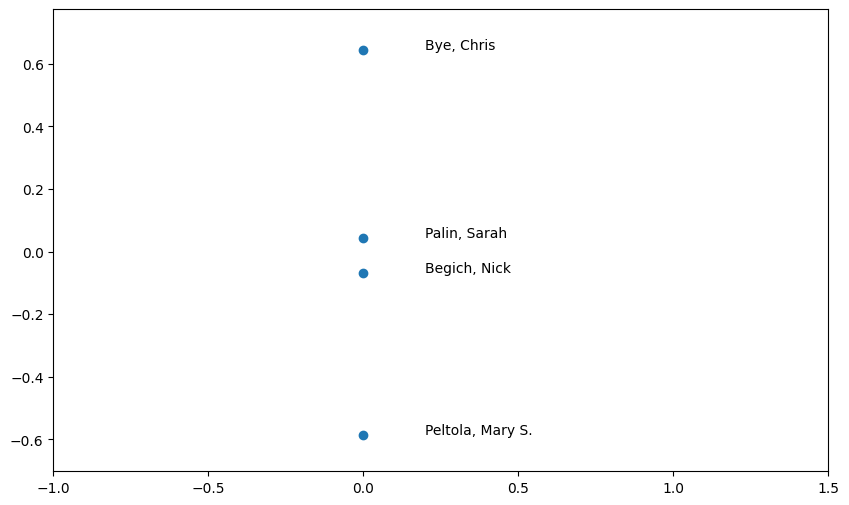

/Users/es5891/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


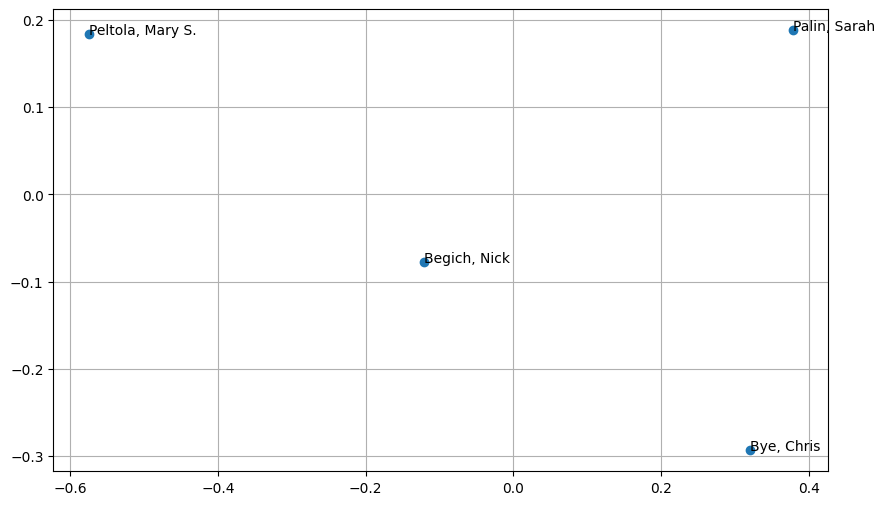

In [17]:
# Test the function with the provided CSV file
perform_rcv_analysis(f"Alaska_11082022_USRepresentative.csv", ignore_values=['skipped', 'overvote', 'writein','Write-in'],metric=False)